In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from pathlib import Path
import random
from tqdm import tqdm

In [ ]:
SEED = 42
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)


In [ ]:
BASE_DIR = Path.cwd()
DATASET_PATH = BASE_DIR/ 'dataset'
CATEGORIES = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
UNKNOWN_CLASS_ID = 6  # Reserved for low-confidence predictions
NUM_CLASSES = len(CATEGORIES) + 1  # 6 known + 1 unknown (for low confidence)
TARGET_COUNT = 700


In [ ]:
def getImages(categoryPath):
    return list(categoryPath.glob('*.jpg'))


def printCategoryCounts():
    print("\nImage counts per category:")
    print("-" * 30)
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imageCount = len(getImages(categoryPath))
        print(f"{categoryName:15s}: {imageCount} images")


def validateAndCleanDataset():
    if not DATASET_PATH.exists():
        raise FileNotFoundError(f"Dataset not found at: {DATASET_PATH}")
    print("Validating dataset for corrupted images...")
    categoryDirectories = [directory for directory in DATASET_PATH.iterdir() if directory.is_dir()]
    print(f"Found {len(categoryDirectories)} categories: {[category.name for category in categoryDirectories]}\n")
    totalRemovedImages = 0
    for categoryDirectory in sorted(categoryDirectories):
        imageFiles = [file for file in categoryDirectory.iterdir() if file.is_file()]
        removedCount = 0
        for imagePath in imageFiles:
            if cv2.imread(str(imagePath)) is None:
                print(f"Removing: {imagePath.name} as it is corrupted.")
                try:
                    os.remove(imagePath)
                    removedCount += 1
                except Exception as error:
                    print(f"Warning: Could not remove: {error}")
        numberOfValidImages = len(imageFiles) - removedCount
        print(f"{categoryDirectory.name}: {numberOfValidImages}/{len(imageFiles)} valid images")
        totalRemovedImages += removedCount
    print(f"\nValidation complete. Removed {totalRemovedImages} corrupted file(s).")
    printCategoryCounts()


def augmentImage(image):
    height, width = image.shape[:2]
    center = (width / 2, height / 2)
    augmentations = [
        cv2.flip(image, 1),  # Horizontal flip
        cv2.flip(image, 0),  # Vertical flip
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 90, 1.0), (width, height)), # 90 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 180, 1.0), (width, height)), # 180 degrees
        cv2.warpAffine(image, cv2.getRotationMatrix2D(center, 270, 1.0), (width, height)), # 270 degrees
        cv2.convertScaleAbs(image, alpha=1.3, beta=30),   # Brightness +30
        cv2.convertScaleAbs(image, alpha=0.7, beta=-30),  # Brightness -30
        cv2.GaussianBlur(image, (5, 5), 0),               # Gaussian blur 5x5
    ]
    # Zoom crop
    scale = 1.2
    newHeight, newWidth = int(height * scale), int(width * scale)
    resized = cv2.resize(image, (newWidth, newHeight))
    startHeight, startWidth = (newHeight - height) // 2, (newWidth - width) // 2
    augmentations.append(resized[startHeight:startHeight + height, startWidth:startWidth + width])
    return augmentations


def augmentDataset():
    print(f"\nAugmenting images to reach {TARGET_COUNT} per category...")
    random.seed(SEED)
    for categoryName in CATEGORIES:
        categoryPath = DATASET_PATH / categoryName
        imagePaths = sorted(getImages(categoryPath))
        currentImageCount = len(imagePaths)
        imagesNeeded = TARGET_COUNT - currentImageCount
        print(f"\n{categoryName}: {currentImageCount} images", end="")
        if imagesNeeded <= 0:
            print(" - Already sufficient")
            continue
        print(f" (Need {imagesNeeded} more)")
        # Load original images using tqdm for progress
        originalImages = [(cv2.imread(str(imageFile)), imageFile.stem) for imageFile in tqdm(imagePaths, desc="Loading")]
        originalImages = [(image, name) for image, name in originalImages]
        # Generate augmented images
        generatedCount = 0
        while generatedCount < imagesNeeded:
            image, imageName = random.choice(originalImages)
            for augmentationIndex, augmentedImage in enumerate(augmentImage(image)):
                if generatedCount >= imagesNeeded:
                    break
                savePath = categoryPath / f"{imageName}_augmented_{generatedCount}_{augmentationIndex}.jpg"
                cv2.imwrite(str(savePath), augmentedImage)
                generatedCount += 1
        print(f"Generated {generatedCount} augmented images")
    print("\n" + "=" * 50)
    print("Augmentation complete.")
    printCategoryCounts()



In [ ]:
validateAndCleanDataset()


In [ ]:
augmentDataset()


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from knn_classifier import KNNMaterialClassifier
from SVM_classifier import SVMClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import shutil


# # Set seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
# Set environment variable to avoid memory fragmentation
  os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Clear CUDA cache if available
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Initial GPU Memory: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB allocated")

# Image size for DenseNet-201
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 60
LEARNING_RATE = 0.0001

# Define preprocessing transforms for DenseNet-201
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Initial GPU Memory: 0.00 GB allocated


In [ ]:
# ============================================================================
# PREPROCESS AND SAVE IMAGES TO DISK (for faster loading)
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING IMAGES AND SAVING TO DISK")
print("=" * 80)

# Define paths for preprocessed data
PREPROCESSED_DIR = BASE_DIR / 'preprocessed_dataset'
PREPROCESSED_TRAIN_DIR = PREPROCESSED_DIR / 'train'
PREPROCESSED_VAL_DIR = PREPROCESSED_DIR / 'val'

# Clear and create preprocessed directories
if PREPROCESSED_DIR.exists():
    print(f"Removing existing preprocessed directory: {PREPROCESSED_DIR}")
    shutil.rmtree(PREPROCESSED_DIR)

PREPROCESSED_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
PREPROCESSED_VAL_DIR.mkdir(parents=True, exist_ok=True)

# Create category subdirectories (only known categories)
for category in CATEGORIES:
    (PREPROCESSED_TRAIN_DIR / category).mkdir(exist_ok=True)
    (PREPROCESSED_VAL_DIR / category).mkdir(exist_ok=True)

print(f"Created preprocessed directories:")
print(f"  Train: {PREPROCESSED_TRAIN_DIR}")
print(f"  Val:   {PREPROCESSED_VAL_DIR}")

# Collect all image paths and labels (only known categories)
print("\nCollecting image paths from augmented dataset...")
image_paths = []
labels = []
label_to_idx = {cat: idx for idx, cat in enumerate(CATEGORIES)}

for category_dir in DATASET_PATH.iterdir():
    if category_dir.is_dir() and category_dir.name in CATEGORIES:
        category = category_dir.name
        for img_path in category_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in {".jpg"}:
                image_paths.append(str(img_path))
                labels.append(label_to_idx[category])

print(f"Total images found: {len(image_paths)}")
print(f"Classes: {CATEGORIES}")
print(f"Label mapping: {label_to_idx}")
print(f"Note: Unknown class (ID={UNKNOWN_CLASS_ID}) will be predicted for low-confidence cases")

# Split into train and validation sets
from sklearn.model_selection import train_test_split as sklearn_split
train_paths, val_paths, train_labels, val_labels = sklearn_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nDataset split:")
print(f"  Training samples: {len(train_paths)}")
print(f"  Validation samples: {len(val_paths)}")

# Function to preprocess and save a single image
def preprocess_and_save_image(img_path, label, save_dir, transform, idx):
    """Preprocess an image and save as tensor"""
    try:
        # Load image
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Warning: Could not load {img_path}")
            return False

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        # Apply transform
        img_tensor = transform(img)

        # Save as .pt file
        category_name = CATEGORIES[label]
        filename = Path(img_path).stem + '.pt'
        save_path = save_dir / category_name / filename
        torch.save(img_tensor, save_path)

        return True
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return False

# Preprocess and save training images
print("\n" + "-" * 80)
print("Preprocessing and saving TRAINING images...")
print("-" * 80)
train_success = 0
for idx, (img_path, label) in enumerate(tqdm(zip(train_paths, train_labels),
                                               total=len(train_paths),
                                               desc="Train images")):
    if preprocess_and_save_image(img_path, label, PREPROCESSED_TRAIN_DIR, train_transform, idx):
        train_success += 1

print(f"Successfully preprocessed and saved {train_success}/{len(train_paths)} training images")

# Preprocess and save validation images
print("\n" + "-" * 80)
print("Preprocessing and saving VALIDATION images...")
print("-" * 80)
val_success = 0
for idx, (img_path, label) in enumerate(tqdm(zip(val_paths, val_labels),
                                              total=len(val_paths),
                                              desc="Val images")):
    if preprocess_and_save_image(img_path, label, PREPROCESSED_VAL_DIR, val_transform, idx):
        val_success += 1

print(f"Successfully preprocessed and saved {val_success}/{len(val_paths)} validation images")

print("\n" + "=" * 80)
print("PREPROCESSING COMPLETE!")
print("=" * 80)
print(f"Preprocessed images saved to: {PREPROCESSED_DIR}")
print(f"  Train: {train_success} images")
print(f"  Val:   {val_success} images")
print("\nThese preprocessed tensors can now be loaded directly for faster training.")
print("=" * 80)


In [ ]:
# ============================================================================
# DATASET CLASS FOR LOADING PREPROCESSED TENSORS
# ============================================================================

import pickle
from concurrent.futures import ThreadPoolExecutor

# Custom Dataset class for loading preprocessed tensors
class PreprocessedTensorDataset(Dataset):
    """Dataset that loads preprocessed tensor files from disk with caching"""
    def __init__(self, preprocessed_dir, categories, cache_file=None):
        self.preprocessed_dir = preprocessed_dir
        # Only use known categories for training
        self.label_to_idx = {cat: idx for idx, cat in enumerate(categories)}

        # Generate cache filename if not provided
        if cache_file is None:
            cache_file = preprocessed_dir.parent / f"{preprocessed_dir.name}_cache.pkl"

        # Try to load from cache first
        if cache_file.exists():
            print(f"Loading cached paths from {cache_file}...")
            with open(cache_file, 'rb') as f:
                cache_data = pickle.load(f)
                self.tensor_paths = cache_data['tensor_paths']
                self.labels = cache_data['labels']
            print(f" Loaded {len(self.tensor_paths)} cached paths in seconds")
        else:
            print(f"Cache not found. Collecting tensor paths from {preprocessed_dir}...")
            self.tensor_paths = []
            self.labels = []

            # Parallel path collection for speed
            def collect_category_paths(category):
                category_dir = preprocessed_dir / category
                if not category_dir.exists():
                    return [], []
                paths = list(category_dir.glob('*.pt'))
                labels = [self.label_to_idx[category]] * len(paths)
                return paths, labels

            # Use ThreadPoolExecutor for parallel I/O
            with ThreadPoolExecutor(max_workers=len(categories)) as executor:
                results = list(executor.map(collect_category_paths, categories))

            # Flatten results
            for paths, labels in results:
                self.tensor_paths.extend(paths)
                self.labels.extend(labels)

            print(f" Collected {len(self.tensor_paths)} tensor paths")

            # Save to cache
            print(f"Saving paths to cache: {cache_file}")
            cache_data = {
                'tensor_paths': self.tensor_paths,
                'labels': self.labels
            }
            with open(cache_file, 'wb') as f:
                pickle.dump(cache_data, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f" Cache saved!")

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor_path = self.tensor_paths[idx]
        label = self.labels[idx]

        # Load preprocessed tensor with weights_only=True for security and speed
        img_tensor = torch.load(tensor_path, map_location='cpu', weights_only=True)

        return img_tensor, label

# Custom Dataset class (original - for comparison)
class WasteDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
# ============================================================================
# CREATE DATALOADERS FROM PREPROCESSED TENSORS
# ============================================================================
print("\n" + "=" * 80)
print("CREATING DATALOADERS FROM PREPROCESSED TENSORS")
print("=" * 80)

# Create datasets from preprocessed tensors with caching
train_dataset = PreprocessedTensorDataset(
    PREPROCESSED_TRAIN_DIR,
    CATEGORIES,
    cache_file=PREPROCESSED_DIR / 'train_cache.pkl'
)
val_dataset = PreprocessedTensorDataset(
    PREPROCESSED_VAL_DIR,
    CATEGORIES,
    cache_file=PREPROCESSED_DIR / 'val_cache.pkl'
)

print(f"\nDataset sizes:")
print(f"  Training: {len(train_dataset)} samples (6 known classes)")
print(f"  Validation: {len(val_dataset)} samples (6 known classes)")
print(f"  Unknown class (ID={UNKNOWN_CLASS_ID}) is NOT in training data")
print(f"  It will be predicted only when confidence < threshold")

# Create dataloaders with optimized settings
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,  # Keep workers alive between epochs
    prefetch_factor=3         # Prefetch 3 batches per worker
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=3
)

print(f"\nDataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Workers: 6 with persistent_workers=True and prefetch_factor=3")
print("\n DataLoaders are now loading preprocessed tensors directly from disk!")
print("  This will be much faster than loading and preprocessing images on-the-fly.")
print("  Path caching makes subsequent runs nearly instant!")
print("=" * 80)


In [ ]:

# Load pre-trained DenseNet-201 and modify for our task
print("\nLoading pre-trained DenseNet-201 model from PyTorch...")
densenet_model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)

# Replace the classifier layer to handle 7 classes (6 known + 1 for low confidence)
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, NUM_CLASSES)

densenet_model = densenet_model.to(device)
print(f"DenseNet-201 loaded with {NUM_CLASSES} output classes")
print(f"  - Training on 6 known classes: {CATEGORIES}")
print(f"  - Class {UNKNOWN_CLASS_ID} reserved for low-confidence predictions")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Gradient accumulation steps (simulate batch size of 32 with 8*4)
ACCUMULATION_STEPS = 4

# Training function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    optimizer.zero_grad()  # Reset gradients once at the start

    for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss = loss / ACCUMULATION_STEPS  # Normalize loss
        loss.backward()

        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * ACCUMULATION_STEPS  # Denormalize for logging
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Store predictions and labels for F1 score
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Clear cache periodically
        if (batch_idx + 1) % 10 == 0:
            torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    return epoch_loss, epoch_acc, epoch_f1

# Validation function
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(tqdm(dataloader, desc="Validation")):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store predictions and labels for F1 score
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Clear cache periodically
            if (batch_idx + 1) % 10 == 0:
                torch.cuda.empty_cache()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100.0 * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted') * 100
    return epoch_loss, epoch_acc, epoch_f1

# Train the model
print("\n" + "=" * 60)
print("Training DenseNet-201 on Waste Classification Dataset")
print("=" * 60)

best_val_acc = 0.0
best_val_f1 = 0.0
train_history = {'loss': [], 'acc': [], 'f1': []}
val_history = {'loss': [], 'acc': [], 'f1': []}

# Early stopping parameters (based on validation accuracy or F1 score)
patience = 5
counter = 0
best_epoch = 0
best_combined_metric = 0.0  # Track best combined score (acc + f1)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 40)

    train_loss, train_acc, train_f1 = train_epoch(densenet_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate_epoch(densenet_model, val_loader, criterion, device)

    train_history['loss'].append(train_loss)
    train_history['acc'].append(train_acc)
    train_history['f1'].append(train_f1)
    val_history['loss'].append(val_loss)
    val_history['acc'].append(val_acc)
    val_history['f1'].append(val_f1)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}% | Val F1:   {val_f1:.2f}%")

    # Track if any metric improved
    improved = False

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f" Best model (by accuracy) saved with Val Acc: {val_acc:.2f}%")
        improved = True

    # Save best model based on validation F1 score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f" Best model (by F1) saved with Val F1: {val_f1:.2f}%")
        improved = True

    # Save overall best model based on combined metric (average of accuracy and F1)
    combined_metric = (val_acc + val_f1) / 2.0
    if combined_metric > best_combined_metric:
        best_combined_metric = combined_metric
        torch.save(densenet_model.state_dict(), 'best_densenet201.pth')
        print(f" Overall best model saved (Combined: {combined_metric:.2f}%)")

    # Early stopping based on validation accuracy or F1 score improvement
    if improved:
        counter = 0
        best_epoch = epoch
        print(f" Metrics improved! Resetting early stopping counter.")
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience} (no improvement in Val Acc or F1)")
        if counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}.")
            print(f"No improvement in validation accuracy or F1 score for {patience} epochs.")
            print(f"Best epoch was {best_epoch+1} with Val Acc: {best_val_acc:.2f}%, Val F1: {best_val_f1:.2f}%")
            break

    scheduler.step()

print("\n" + "=" * 60)
print(f"Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Best validation F1 score: {best_val_f1:.2f}%")
print(f"  Best combined metric: {best_combined_metric:.2f}%")
print(f"  Best epoch: {best_epoch + 1}")
print("=" * 60)


Loading pre-trained DenseNet-201 model from PyTorch...
DenseNet-201 loaded with 7 output classes
  - Training on 6 known classes: ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']
  - Class 6 reserved for low-confidence predictions

Training DenseNet-201 on Waste Classification Dataset

Epoch 1/60
----------------------------------------


NameError: name 'train_loader' is not defined

In [ ]:

# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
ax1.plot(train_history['loss'], 'b-o', label='Training Loss', linewidth=2, markersize=6)
ax1.plot(val_history['loss'], 'r-s', label='Validation Loss', linewidth=2, markersize=6)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(train_history['acc'], 'b-o', label='Training Accuracy', linewidth=2, markersize=6)
ax2.plot(val_history['acc'], 'r-s', label='Validation Accuracy', linewidth=2, markersize=6)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot F1 score
ax3.plot(train_history['f1'], 'b-o', label='Training F1 Score', linewidth=2, markersize=6)
ax3.plot(val_history['f1'], 'r-s', label='Validation F1 Score', linewidth=2, markersize=6)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('F1 Score (%)', fontsize=12)
ax3.set_title('Training and Validation F1 Score', fontsize=14)
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:

# Load best model for feature extraction
print("\nLoading best trained DenseNet-201 model for feature extraction...")
densenet_model.load_state_dict(torch.load('best_densenet201.pth'))

# Create feature extractor (remove classifier)
cnn_model = nn.Sequential(
    densenet_model.features,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)
cnn_model = cnn_model.to(device)
cnn_model.eval()  # Set to evaluation mode
print(f"CNN Feature Extractor ready. Output shape: (batch_size, 1920)")

# Define preprocessing for feature extraction
preprocess = val_transform

def extract_cnn_features(img_path):
    """Extract features from an image using pre-trained DenseNet-201."""
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = cnn_model(img_tensor)
        # features shape: (1, 1920)
        features = features.view(-1).cpu().numpy()  # Always flatten to (1920,)
        return features
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None
print(f"Feature vector size: 1920 dimensions (DenseNet-201 output)")


Loading best trained DenseNet-201 model for feature extraction...
CNN Feature Extractor ready. Output shape: (batch_size, 1920)
Feature vector size: 1920 dimensions (DenseNet-201 output)


In [ ]:
# Rebuild rows from disk (only known categories)
rows = []
for category_dir in DATASET_PATH.iterdir():
    if category_dir.is_dir() and category_dir.name in CATEGORIES:
        category = category_dir.name
        for img_path in category_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in {".jpg"}:
                rows.append({"filename": str(img_path), "category": category})

df = pd.DataFrame(rows)
print(f"Total images found: {len(df)}")

# Extract features for all images
features, labels = [], []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting CNN features"):
    feat = extract_cnn_features(row["filename"])
    if feat is not None:
        features.append(feat)
        labels.append(row["category"])

X = np.array(features, dtype=np.float32)
y = np.array(labels)

# Encode labels (only known categories)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=SEED, stratify=y_encoded
)

print(f"\nDataset split:")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples:   {len(X_test)}")
print(f"  Feature dimensions: {X.shape[1]}")
print(f"  Classes in dataset: {list(le.classes_)} (6 known classes)")
print(f"  Note: 'unknown' class (ID={UNKNOWN_CLASS_ID}) is NOT in training data")
print(f"        It will only be predicted when confidence < threshold")


Total images found: 4200


Extracting CNN features: 100%|██████████████████████████████████████████████████████████████████████████████| 4200/4200 [02:43<00:00, 25.73it/s]


Dataset split:
  Training samples: 3360
  Testing samples:   840
  Feature dimensions: 1920
  Classes in dataset: [np.str_('cardboard'), np.str_('glass'), np.str_('metal'), np.str_('paper'), np.str_('plastic'), np.str_('trash')] (6 known classes)
  Note: 'unknown' class (ID=6) is NOT in training data
        It will only be predicted when confidence < threshold


In [ ]:
# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Experiment with different k values
k_values = [3, 5, 7, 9, 11, 15]
results = []

print("=" * 60)
print("KNN Experiments with Different k Values")
print("=" * 60)

# Initialize train_acc and test_acc with default values
train_acc, test_acc = 0.0, 0.0

for k in k_values:
    knn = KNNMaterialClassifier(k=k, weighting='distance')
    knn.train(X_train_scaled, y_train)

    # Predict with custom KNN
    y_train_pred_temp = np.array([knn.predict(x) for x in X_train_scaled])
    y_test_pred_temp = np.array([knn.predict(x) for x in X_test_scaled])

    train_acc = accuracy_score(y_train, y_train_pred_temp)
    test_acc = accuracy_score(y_test, y_test_pred_temp)

    results.append({'k': k, 'train_acc': train_acc, 'test_acc': test_acc})
    print(f"k={k:2d}  |  Train Accuracy: {train_acc:.4f}  |  Test Accuracy: {test_acc:.4f}")

# Find best k
best_result = max(results, key=lambda x: x['test_acc'])
print("\n" + "=" * 60)
print(f"Best k = {best_result['k']} with Test Accuracy = {best_result['test_acc']:.4f}")
print("=" * 60)


KNN Experiments with Different k Values
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  2.24it/s]


KNN Training Complete!
k= 3  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9917
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  4.46it/s]


KNN Training Complete!
k= 5  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9893
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  6.03it/s]


KNN Training Complete!
k= 7  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9893
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  4.52it/s]


KNN Training Complete!
k= 9  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9893
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  5.25it/s]


KNN Training Complete!
k=11  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9893
Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  5.63it/s]


KNN Training Complete!
k=15  |  Train Accuracy: 1.0000  |  Test Accuracy: 0.9893

Best k = 3 with Test Accuracy = 0.9917


In [ ]:
# Train final model with best k
best_k = best_result['k']
knn_best = KNNMaterialClassifier(k=best_k, weighting='distance')
knn_best.train(X_train_scaled, y_train)

# Predictions
y_train_pred = np.array([knn_best.predict(x) for x in X_train_scaled])
y_test_pred = np.array([knn_best.predict(x) for x in X_test_scaled])

# Final accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate F1 scores
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
f1_diff = abs(train_f1 - test_f1) * 100  # Convert to percentage

print(f"Final KNN Model (k={best_k})")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Training F1 Score: {train_f1:.4f} ({train_f1*100:.2f}%)")
print(f"Testing F1 Score:  {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"F1 Score Difference: {f1_diff:.2f}%")
print("=" * 60)

# Count how many predictions are 'unknown' (class 6)
unknown_count_test = np.sum(y_test_pred == UNKNOWN_CLASS_ID)
unknown_count_train = np.sum(y_train_pred == UNKNOWN_CLASS_ID)

print(f"\nUnknown class predictions:")
print(f"  Test set: {unknown_count_test}/{len(y_test_pred)} ({unknown_count_test/len(y_test_pred)*100:.2f}%)")
print(f"  Train set: {unknown_count_train}/{len(y_train_pred)} ({unknown_count_train/len(y_train_pred)*100:.2f}%)")

print("\nClassification Report (Test Set):")
# Filter out unknown class predictions for classification report
mask_test = y_test_pred != UNKNOWN_CLASS_ID
if np.sum(mask_test) > 0:
    print(classification_report(y_test[mask_test], y_test_pred[mask_test],
                                target_names=le.classes_, labels=range(len(le.classes_))))
else:
    print("No predictions with known classes (all predictions are unknown)")

print("\nClassification Report (Train Set):")
# Filter out unknown class predictions for classification report
mask_train = y_train_pred != UNKNOWN_CLASS_ID
if np.sum(mask_train) > 0:
    print(classification_report(y_train[mask_train], y_train_pred[mask_train],
                                target_names=le.classes_, labels=range(len(le.classes_))))
else:
    print("No predictions with known classes (all predictions are unknown)")


Training KNN Classifier...


Fitting KNN Model: : 2it [00:00,  4.30it/s]


KNN Training Complete!
Final KNN Model (k=3)
Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:   0.9917 (99.17%)
Training F1 Score: 1.0000 (100.00%)
Testing F1 Score:  0.9917 (99.17%)
F1 Score Difference: 0.83%

Unknown class predictions:
  Test set: 0/840 (0.00%)
  Train set: 0/3360 (0.00%)

Classification Report (Test Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       140
       glass       0.98      1.00      0.99       140
       metal       0.99      0.99      0.99       140
       paper       0.99      1.00      1.00       140
     plastic       0.99      0.99      0.99       140
       trash       1.00      0.98      0.99       140

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840


Classification Report (Train Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00 

In [ ]:
print("\n" + "=" * 60)
print("SVM Experiments with Different Kernels and Parameters")
print("=" * 60)

# Test different SVM configurations
svm_results = []
svm_configs = [
    {'kernel': 'linear', 'C': 1.0, 'name': 'Linear (C=1.0)'},
    {'kernel': 'linear', 'C': 10.0, 'name': 'Linear (C=10.0)'},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale', 'name': 'RBF (C=1.0, gamma=scale)'},
    {'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale', 'name': 'RBF (C=10.0, gamma=scale)'},
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'auto', 'name': 'RBF (C=1.0, gamma=auto)'},
]

for config in svm_configs:
    print(f"\nTraining {config['name']}...")
    name = config.pop('name')

    svm = SVMClassifier(**config)
    svm.train_model(X_train_scaled, y_train)

    # Predict with custom SVM
    y_train_pred_temp = np.array([svm.predict_data(x) for x in X_train_scaled])
    y_test_pred_temp = np.array([svm.predict_data(x) for x in X_test_scaled])

    svm_results.append({'name': name, 'train_acc': train_acc, 'test_acc': test_acc, 'config': config})
    print(f"{name:40s}  |  Train Acc: {train_acc:.4f}  |  Test Acc: {test_acc:.4f}")

# Find best SVM configuration
best_svm_result = max(svm_results, key=lambda x: x['test_acc'])
print("\n" + "=" * 60)
print(f"Best SVM: {best_svm_result['name']}")
print(f"Test Accuracy: {best_svm_result['test_acc']:.4f}")
print("=" * 60)



SVM Experiments with Different Kernels and Parameters

Training Linear (C=1.0)...
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]


SVM Training Complete!
Linear (C=1.0)                            |  Train Acc: 1.0000  |  Test Acc: 0.9893

Training Linear (C=10.0)...
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.25s/it]


SVM Training Complete!
Linear (C=10.0)                           |  Train Acc: 1.0000  |  Test Acc: 0.9893

Training RBF (C=1.0, gamma=scale)...
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.02s/it]


SVM Training Complete!
RBF (C=1.0, gamma=scale)                  |  Train Acc: 1.0000  |  Test Acc: 0.9893

Training RBF (C=10.0, gamma=scale)...
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.29s/it]


SVM Training Complete!
RBF (C=10.0, gamma=scale)                 |  Train Acc: 1.0000  |  Test Acc: 0.9893

Training RBF (C=1.0, gamma=auto)...
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.41s/it]


SVM Training Complete!
RBF (C=1.0, gamma=auto)                   |  Train Acc: 1.0000  |  Test Acc: 0.9893

Best SVM: Linear (C=1.0)
Test Accuracy: 0.9893


In [ ]:
# Train final SVM model with best configuration
print(f"Training final SVM model: {best_svm_result['name']}")
best_svm = SVMClassifier(**best_svm_result['config'])
best_svm.train_model(X_train_scaled, y_train)

# Predictions
y_train_pred_svm = np.array([best_svm.predict_data(x) for x in X_train_scaled])
y_test_pred_svm = np.array([best_svm.predict_data(x) for x in X_test_scaled])

# Final accuracies
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

# Calculate F1 scores
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='weighted')
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='weighted')
f1_diff_svm = abs(train_f1_svm - test_f1_svm) * 100  # Convert to percentage

print(f"\nFinal SVM Model ({best_svm_result['name']})")
print("=" * 60)
print(f"Training Accuracy: {train_accuracy_svm:.4f} ({train_accuracy_svm*100:.2f}%)")
print(f"Testing Accuracy:   {test_accuracy_svm:.4f} ({test_accuracy_svm*100:.2f}%)")
print(f"Training F1 Score: {train_f1_svm:.4f} ({train_f1_svm*100:.2f}%)")
print(f"Testing F1 Score:  {test_f1_svm:.4f} ({test_f1_svm*100:.2f}%)")
print(f"F1 Score Difference: {f1_diff_svm:.2f}%")
print("=" * 60)

# Count how many predictions are 'unknown' (class 6)
unknown_count_test = np.sum(y_test_pred_svm == UNKNOWN_CLASS_ID)
unknown_count_train = np.sum(y_train_pred_svm == UNKNOWN_CLASS_ID)

print(f"\nUnknown class predictions:")
print(f"  Test set: {unknown_count_test}/{len(y_test_pred_svm)} ({unknown_count_test/len(y_test_pred_svm)*100:.2f}%)")
print(f"  Train set: {unknown_count_train}/{len(y_train_pred_svm)} ({unknown_count_train/len(y_train_pred_svm)*100:.2f}%)")

print("\nClassification Report (Test Set):")
# Filter out unknown class predictions for classification report
mask_test = y_test_pred_svm != UNKNOWN_CLASS_ID
if np.sum(mask_test) > 0:
    print(classification_report(y_test[mask_test], y_test_pred_svm[mask_test],
                                target_names=le.classes_, labels=range(len(le.classes_))))
else:
    print("No predictions with known classes (all predictions are unknown)")

print("\nClassification Report (Train Set):")
# Filter out unknown class predictions for classification report
mask_train = y_train_pred_svm != UNKNOWN_CLASS_ID
if np.sum(mask_train) > 0:
    print(classification_report(y_train[mask_train], y_train_pred_svm[mask_train],
                                target_names=le.classes_, labels=range(len(le.classes_))))
else:
    print("No predictions with known classes (all predictions are unknown)")


Training final SVM model: Linear (C=1.0)
Training SVM Classifier...


Fitting SVM Model: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.31s/it]


SVM Training Complete!

Final SVM Model (Linear (C=1.0))
Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:   0.9881 (98.81%)
Training F1 Score: 1.0000 (100.00%)
Testing F1 Score:  0.9910 (99.10%)
F1 Score Difference: 0.90%

Unknown class predictions:
  Test set: 5/840 (0.60%)
  Train set: 0/3360 (0.00%)

Classification Report (Test Set):
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00       140
       glass       0.98      0.99      0.99       140
       metal       0.99      0.99      0.99       139
       paper       1.00      1.00      1.00       140
     plastic       0.99      1.00      1.00       138
       trash       1.00      0.99      0.99       138

    accuracy                           0.99       835
   macro avg       0.99      0.99      0.99       835
weighted avg       0.99      0.99      0.99       835


Classification Report (Train Set):
              precision    recall  f1-score   support

   cardboard       1.0


PLOTTING CONFUSION MATRICES (TEST SET ONLY - 6 KNOWN CLASSES)


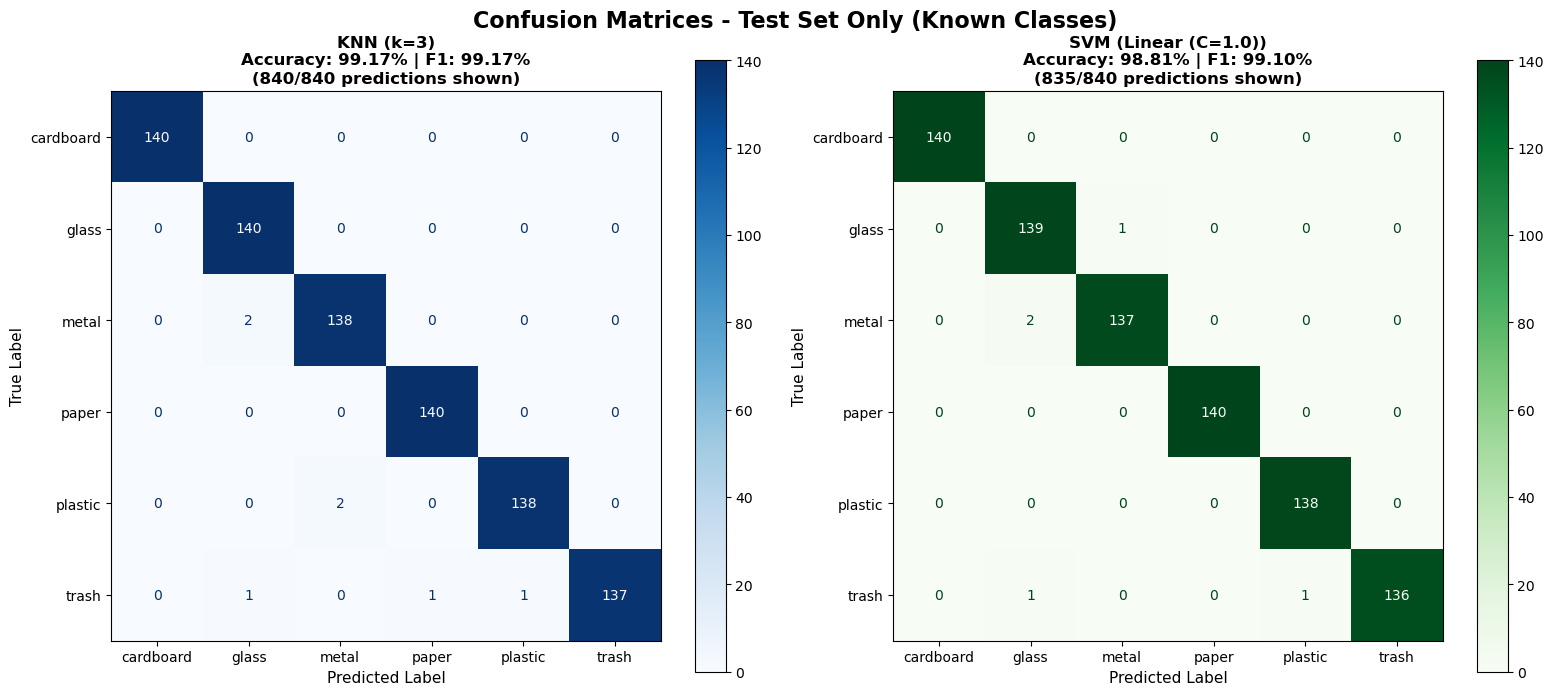


✓ Confusion matrices plotted successfully!
  Note: Only 6 known classes shown (unknown predictions excluded)
  KNN unknown predictions excluded: 0/840
  SVM unknown predictions excluded: 5/840


In [ ]:
# ============================================================================
# PLOT CONFUSION MATRICES FOR KNN AND SVM (TEST SET ONLY)
# ============================================================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("PLOTTING CONFUSION MATRICES (TEST SET ONLY - 6 KNOWN CLASSES)")
print("=" * 80)

# Filter out unknown class predictions
mask_knn_test = y_test_pred != UNKNOWN_CLASS_ID
mask_svm_test = y_test_pred_svm != UNKNOWN_CLASS_ID

# Create figure with 1x2 subplots (KNN test, SVM test)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Confusion Matrices - Test Set Only (Known Classes)', fontsize=16, fontweight='bold')

# KNN - Test Set (6 known classes only)
cm_knn_test = confusion_matrix(y_test[mask_knn_test], y_test_pred[mask_knn_test], labels=range(len(le.classes_)))
disp_knn_test = ConfusionMatrixDisplay(confusion_matrix=cm_knn_test, display_labels=le.classes_)
disp_knn_test.plot(ax=axes[0], cmap='Blues', colorbar=True, values_format='d')
axes[0].set_title(f'KNN (k={best_k})\nAccuracy: {test_accuracy*100:.2f}% | F1: {test_f1*100:.2f}%\n({np.sum(mask_knn_test)}/{len(y_test_pred)} predictions shown)',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_ylabel('True Label', fontsize=11)

# SVM - Test Set (6 known classes only)
cm_svm_test = confusion_matrix(y_test[mask_svm_test], y_test_pred_svm[mask_svm_test], labels=range(len(le.classes_)))
disp_svm_test = ConfusionMatrixDisplay(confusion_matrix=cm_svm_test, display_labels=le.classes_)
disp_svm_test.plot(ax=axes[1], cmap='Greens', colorbar=True, values_format='d')
axes[1].set_title(f'SVM ({best_svm_result["name"]})\nAccuracy: {test_accuracy_svm*100:.2f}% | F1: {test_f1_svm*100:.2f}%\n({np.sum(mask_svm_test)}/{len(y_test_pred_svm)} predictions shown)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)

plt.tight_layout()
plt.show()

print("\n✓ Confusion matrices plotted successfully!")
print(f"  Note: Only 6 known classes shown (unknown predictions excluded)")
print(f"  KNN unknown predictions excluded: {np.sum(~mask_knn_test)}/{len(y_test_pred)}")
print(f"  SVM unknown predictions excluded: {np.sum(~mask_svm_test)}/{len(y_test_pred_svm)}")
print("=" * 80)


In [ ]:
# ============================================================================
# SAVE ALL BEST MODEL WEIGHTS AND ARTIFACTS
# ============================================================================

import joblib
print("\n" + "=" * 80)
print("SAVING ALL BEST MODEL WEIGHTS AND ARTIFACTS")
print("=" * 80)

# Create models directory if it doesn't exist
MODELS_DIR = BASE_DIR / 'best_models'
MODELS_DIR.mkdir(exist_ok=True)
print(f"\nModels will be saved to: {MODELS_DIR}")

# 1. Save DenseNet-201 weights
densenet_path = MODELS_DIR / 'best_densenet201.pth'
torch.save(densenet_model.state_dict(), densenet_path)
print(f"\n DenseNet-201 weights saved to: {densenet_path}")
print(f"  - Best validation accuracy: {best_val_acc:.2f}%")
print(f"  - Best validation F1 score: {best_val_f1:.2f}%")
print(f"  - Best combined metric: {best_combined_metric:.2f}%")

# 2. Save KNN model
knn_path = MODELS_DIR / 'best_knn_model.pkl'
knn_best.save(knn_path)
print(f"\n KNN model saved to: {knn_path}")
print(f"  - k: {best_k}")
print(f"  - Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  - Test F1 score: {test_f1:.4f} ({test_f1*100:.2f}%)")

# 3. Save SVM model
svm_path = MODELS_DIR / 'best_svm_model.pkl'
best_svm.save_model_on_disk(svm_path)
print(f"\n SVM model saved to: {svm_path}")
print(f"  - Configuration: {best_svm_result['name']}")
print(f"  - Test accuracy: {test_accuracy_svm:.4f} ({test_accuracy_svm*100:.2f}%)")
print(f"  - Test F1 score: {test_f1_svm:.4f} ({test_f1_svm*100:.2f}%)")

# 4. Save feature scaler
scaler_path = MODELS_DIR / 'feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"\nFeature scaler saved to: {scaler_path}")

# 5. Save label encoder
encoder_path = MODELS_DIR / 'label_encoder.pkl'
joblib.dump(le, encoder_path)
print(f"\nLabel encoder saved to: {encoder_path}")

print("\n" + "=" * 80)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("=" * 80)
print(f"\nSaved files in {MODELS_DIR}:")
print(f"  1. {densenet_path.name} - DenseNet-201 weights")
print(f"  2. {knn_path.name} - KNN classifier")
print(f"  3. {svm_path.name} - SVM classifier")
print(f"  4. {scaler_path.name} - Feature scaler")
print(f"  5. {encoder_path.name} - Label encoder")
print("=" * 80)